### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [4]:
# libraries
import os
import sys
import platform
print(sys.version)

strong_pc = platform.system() == 'Linux'
in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules and False:
        print('Installing keras')
        !pip install keras==2.11.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0


if 'DEEPNOTE_ENV' in os.environ:
    os.chdir('/..')
    os.chdir('datasets')
    os.chdir('googledrivedeepnoteintegration')
    os.chdir('Human_Data_Analytics_Project_2023')
    if not 'librosa' in sys.modules:
        print('Installing Librosa')
        !pip install librosa
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

# GPU SETTINGS FOR LINUX and repressing warnings for windows. References for gpu: https://www.tensorflow.org/guide/gpu
show_gpu_activity = False
if sys.platform == 'linux':
    if show_gpu_activity:
        tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only allocate a part of memory on the first GPU
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=6800)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
else:
    warnings.filterwarnings("ignore", category=UserWarning)

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 44100

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
installing keras tuner
Adding the folder for the modules
TensorFlow version: 2.11.1
keras version = 2.11.0


# 4 ENCODER FOR HIGH-LEVEL FEATURE EXTRACTION

In [5]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 4.1 Classification on encoded raw audio

Since neither the basic machine learning appraches nor the dense feed forward NNs were able to achieve a good accuracy, we decided to use only the RNN approach, which at least achived alone 28% of accurcy on the 10 class classification problem from raw audio.

### Create the dataset

The max value is 0.99884033203125
Audio shape: (128, 220500, 1)
Label shape: (128, 10)
Label: dog


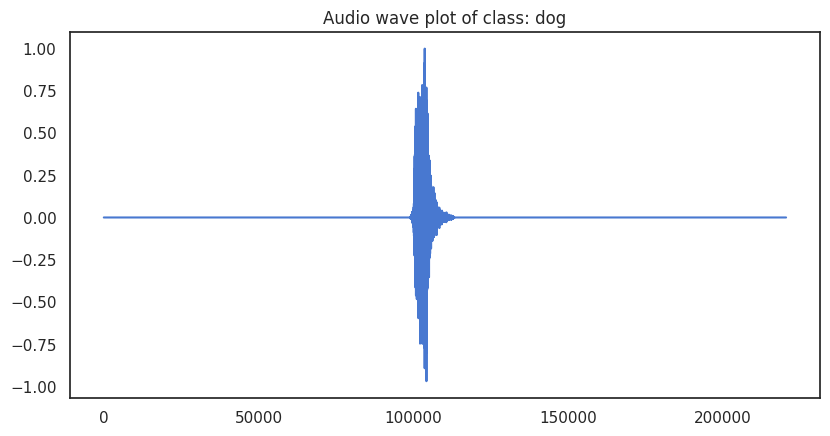

In [ ]:
batch_size = 30 if not strong_pc else 128

dataset, label = create_dataset_lite(df_ESC10,
                                     batch_size = batch_size,
                                     ndim = 2)
INPUT_DIM, n_labels = example_batch(dataset, label_names = list(label.columns), verbose = 1)

### Load the encoder and build the model

In [7]:
AE_name = 'Dense_AE_ffnn'
path_to_AE = os.path.join(main_dir, 'Saved_Models', AE_name)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_raw'


FileNotFoundError: ignored

In [ ]:
def build_model(
    encoder = encoder,
    n_labels = n_labels,
    INPUT_DIM = INPUT_DIM,
    n_units = 8,
    activation = 'tanh',
    #arguments to compile the model
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    learning_rate = 1e-3,
    metrics = ['accuracy'],
    verbose = 0,
    compile = True,
    name = Classifier_name
):

    classifier = tf.keras.Sequential([
        tf.keras.layers.GRU(units=n_units, activation=activation),
        tf.keras.layers.Dense(n_labels, activation='softmax')
    ], name = 'Classifier')

    # build the model with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 2)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)

    if compile:
        # compile the model
        model.compile(loss = loss,
                      optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics = metrics)
        if verbose > 0:
            model.summary()

    return model

In [ ]:
model = build_model()
model.summary()

### Run a Grid Search to find the best hyperparameters

In [ ]:
strong_pc = False

In [ ]:
params = {'learning_rate':[1e-3, 1e-4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh']}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 5
model_cv, result, best_params = K_fold_training(dataset,
                                                build_model,
                                                params = params,
                                                epochs = epochs,
                                                patience = patience,
                                                verbose = verbose,
                                                K=K_fold)


(400, 220500, 1)
(400, 10)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
3/3 [==============================] - 1s 24ms/step
accuracy on test for this fold is 0.0875
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 19ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 24ms/step
accuracy on test for this fold is 0.175
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 29ms/step
accuracy on test for this fold is 0.125
3/3 [==============================] - 1s 22ms/step
accuracy on test for this fold is 0.0625
3/3 [==============================] - 1s 31ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 23ms/step
accuracy on test for this fold is 0.1
3/3 [==============================] - 1s 23ms/step
accuracy on test for this fold is 0.05
Th

mean_accuracy
{'learning_rate': 0.001}          0.1125
{'learning_rate': 0.0001}         0.0875

### Train the model

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.
Model: "encoder_classifier_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 220500, 1)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 16)                14114944  
                                                                 
 tf.expand_dims_14 (TFOpLamb  (None, 16, 1)            0         
 da)                                                             
                                                                 
 Classifier (Sequential)     (None, 10)                354       
                                                                 
Total params: 14,115,298
Trainable params: 354
Non-trainable params: 14,114,944
___________________________________________________________

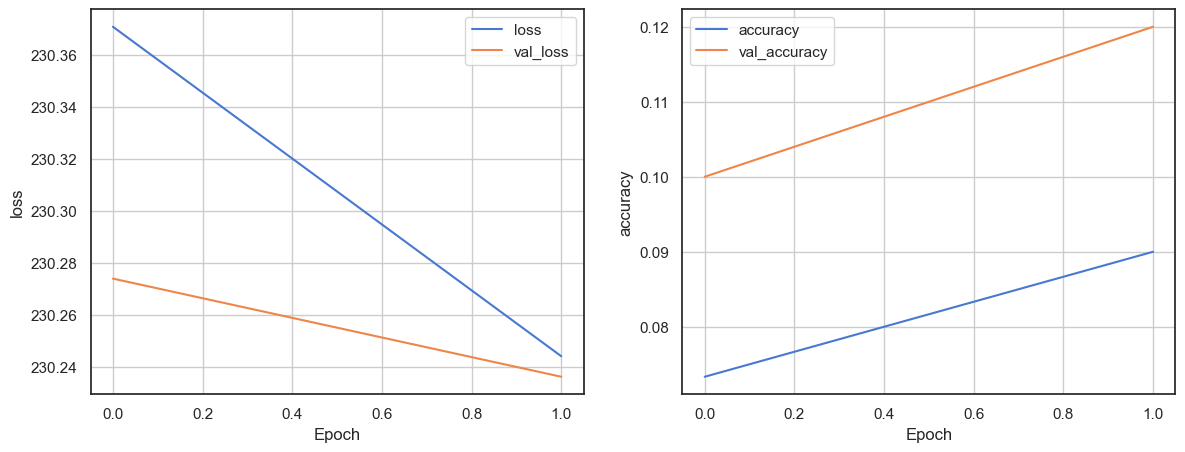

2/2 [==============================] - 2s 568ms/step - loss: 2.3060 - accuracy: 0.0200


{'loss': 2.306018352508545, 'accuracy': 0.019999999552965164}

2/2 [==============================] - 1s 19ms/step


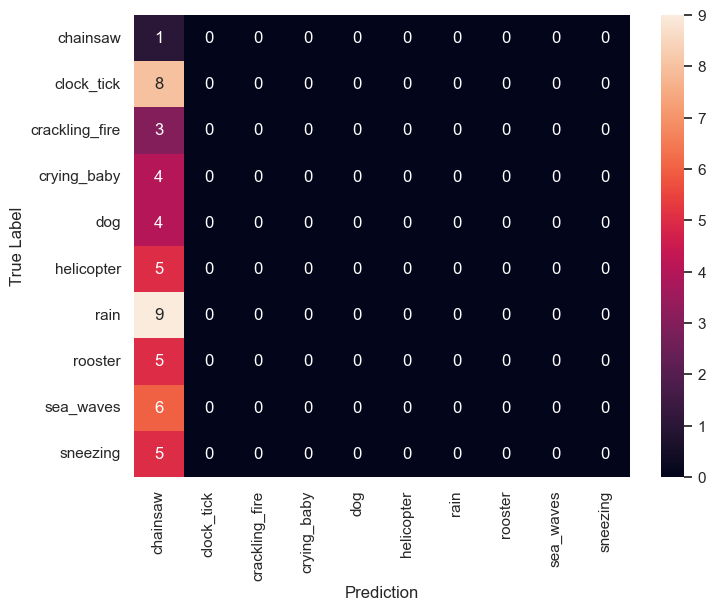

The most misclassified class is chainsaw
Audio category: chainsaw


The are more audio predicted as chainsaw then actually is:
Audio category misclassified as chainsaw: rain


In [ ]:
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'Data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = None
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 2,
                                                                      )

#build the model with the best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
learning_rate = best_params['learning_rate']
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

## 4.2 Classification on encoded spectrograms - RNN

In [16]:
strong_pc = False

### Short Time Fourier Transform

#### Create dataset

Preprocessing: STFT
Resizing with shape: 64x128
The max value is 80.0
Audio shape: (30, 64, 128, 1)
Label shape: (30, 10)
Label: dog


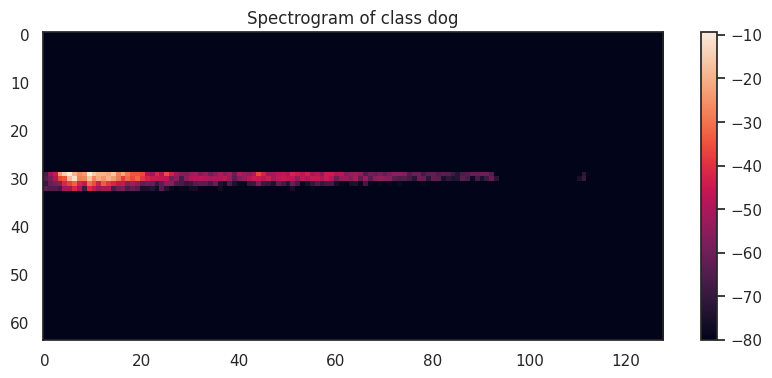

In [17]:
batch_size = 30 if not strong_pc else 128
preprocessing = 'STFT'
n_dim = 3

dataset_STFT, label_STFT = create_dataset_lite(df_ESC10,
                                         batch_size = batch_size,
                                         preprocessing = preprocessing,
                                         ndim = n_dim,
                                         resize = True)

INPUT_DIM, n_labels = example_batch(dataset_STFT, label_names = list(label_STFT.columns),verbose=2, show_figure = True)

#### Load the encoders and build the model

We trained 2 AEs to produce a vectorial code. On these code we are going to train a RNN classifier.

In [18]:
AE_STFT = 'AE_Conv_prep_flatten_STFT'

path_to_AE = os.path.join(main_dir, 'Saved_Models',AE_STFT)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_flat_code_STFT'

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 21, 42, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 14, 16)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                50208     
                                                                 
Total params: 50,368
Trainable params: 0
Non-trainable params: 50,368
_________________________________________________________________


In [19]:
def build_model(
        encoder = encoder,
        INPUT_DIM = INPUT_DIM,
        n_labels = n_labels,
        n_units = 8,
        activation = 'tanh',
        n_hidden_layers = 1,
        #arguments to compile the model
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        learning_rate = 1e-3,
        metrics = ['accuracy'],
        verbose = 0,
        compile = True
):

    # Define Simple RNN  model
    classifier = tf.keras.Sequential(name = 'classifier')
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            classifier.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, return_sequences = True if i < n_hidden_layers - 1 else False))
    classifier.add(tf.keras.layers.Flatten())
    classifier.add(tf.keras.layers.Dense(n_labels, activation='softmax', name = 'Final_dense'))

    # build the model with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 1)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)

    if compile:
        # compile the model
        model.compile(loss = loss,
                      optimizer = optimizer,
                      metrics = metrics)
        if verbose > 0:
            display(model.summary())

    return model


In [20]:
#model = build_model(encoder = encoder_list[0] , n_hidden_layers = 5 )
model = build_model( n_hidden_layers = 5 )

display(model.summary(line_length = 100))
display(model.layers[1].summary(line_length = 100))
display(model.layers[3].summary(line_length = 100))


Model: "encoder_classifier_flat_code_STFT"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_8 (InputLayer)                        [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 32)                              50368          
                                                                                                    
 tf.expand_dims_7 (TFOpLambda)               (None, 1, 32)                           0              
                                                                                                    
 classifier (Sequential)                     (None, 10)                              20282          
                                                

None

Model: "Encoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_1 (Conv2D)                           (None, 21, 42, 16)                      160            
                                                                                                    
 max_pooling2d_1 (MaxPooling2D)              (None, 7, 14, 16)                       0              
                                                                                                    
 flatten_1 (Flatten)                         (None, 1568)                            0              
                                                                                                    
 dense_2 (Dense)                             (None, 32)                              50208          
                                                                          

None

Model: "classifier"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 gru_14 (GRU)                                (None, 1, 16)                           2400           
                                                                                                    
 gru_15 (GRU)                                (None, 1, 24)                           3024           
                                                                                                    
 gru_16 (GRU)                                (None, 1, 32)                           5568           
                                                                                                    
 gru_17 (GRU)                                (None, 40)                              8880           
                                                                       

None

#### Run a Grid Search to find the best hyperparameters

In [21]:
params = {'n_hidden_layers':[2,4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh'], 'n_hidden_layers':[1,2,3,4]}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 2#5

model_cv, result, best_params = K_fold_training(dataset_STFT,
                                                build_model,
                                                params = params,
                                                epochs = epochs,
                                                patience = patience,
                                                verbose = verbose,
                                                K=K_fold)



(400, 64, 128, 1)
(400, 10)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
accuracy on test for this fold is 0.07
[CV 1/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.070) total time=   3.8s
accuracy on test for this fold is 0.135
[CV 2/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.135) total time=   5.3s
accuracy on test for this fold is 0.09
[CV 1/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.090) total time=  10.9s
accuracy on test for this fold is 0.06
[CV 2/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.060) total time=  10.8s
The best parameters are {'n_hidden_layers': 2}
The accuracy score are


mean_accuracy
{'n_hidden_layers': 2}         0.1025
{'n_hidden_layers': 4}         0.0750

#### Train the model

In [30]:
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'Data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = 'STFT'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 3,
                                                                      resize = True
                                                                      )

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


Model: "encoder_classifier_flat_code_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 tf.expand_dims_15 (TFOpLamb  (None, 1, 32)            0         
 da)                                                             
                                                                 
 classifier (Sequential)     (None, 10)                2570      
                                                                 
Total params: 52,938
Trainable params: 2,570
Non-trainable params: 50,368
_________________________________________________________________
Epoch 1/2
10/10 [==============================] - 18s 2s/step - loss: 2.3623 - accuracy: 0

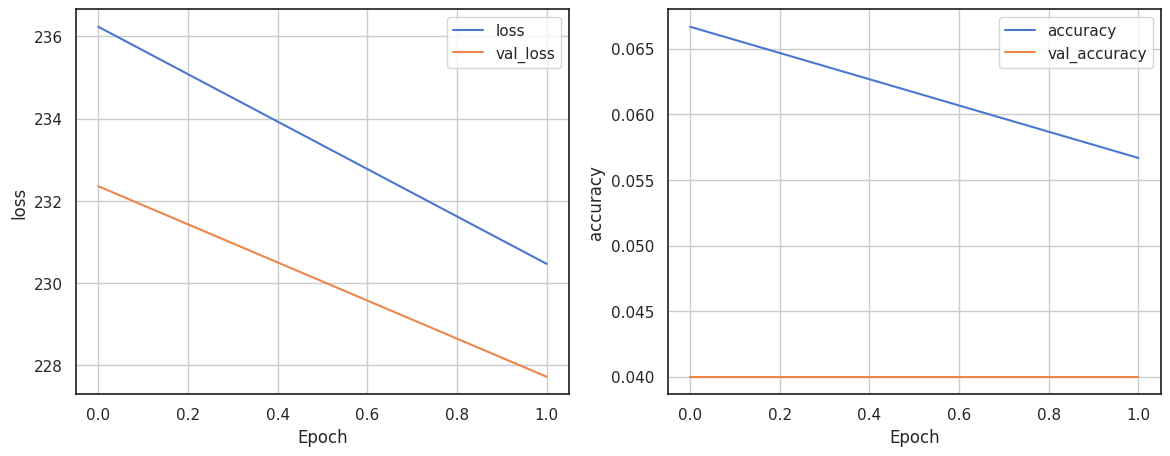

2/2 [==============================] - 2s 502ms/step - loss: 2.2979 - accuracy: 0.0600


{'loss': 2.2979094982147217, 'accuracy': 0.05999999865889549}

2/2 [==============================] - 0s 11ms/step


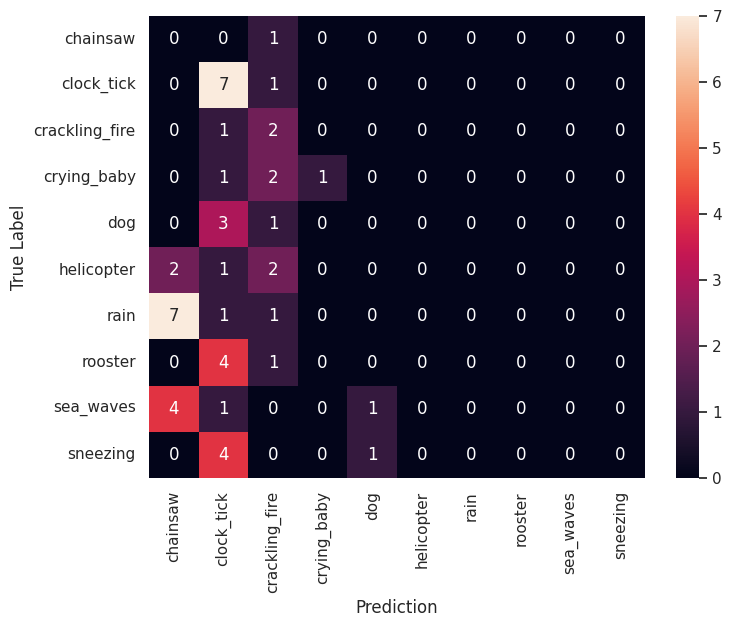

The most misclassified class is clock_tick
Audio category: clock_tick


The are more audio predicted as clock_tick then actually is:
Audio category misclassified as clock_tick: sneezing


In [34]:
#build the model with the best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
#learning_rate = best_params['learning_rate']
learning_rate = 1e-3
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val, test, label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

### Mel Frequency Cepstral Coefficients

#### Create the dataset

Preprocessing: MFCC
Resizing with shape: 64x128
The max value is 445.77911376953125
Audio shape: (30, 64, 128, 1)
Label shape: (30, 10)
Label: dog


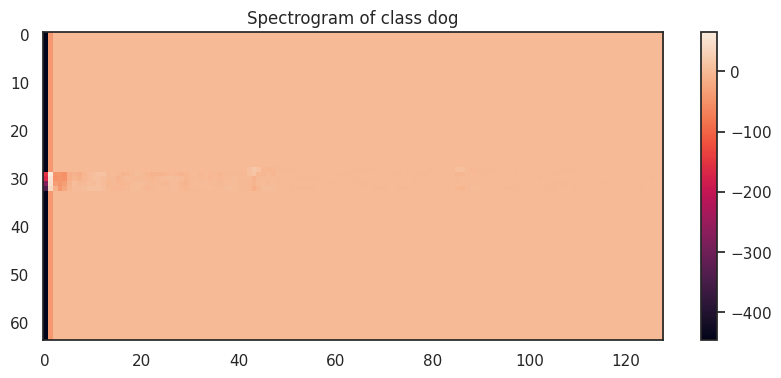

In [35]:
batch_size = 30 if not strong_pc else 128
preprocessing = 'MFCC'
n_dim = 3

dataset_MFCC, label_MFCC = create_dataset_lite(df_ESC10,
                                         batch_size = batch_size,
                                         preprocessing = preprocessing,
                                         ndim = n_dim,
                                         resize = True)

INPUT_DIM, n_labels = example_batch(dataset_MFCC, label_names = list(label_MFCC.columns),verbose=2, show_figure = True)

#### Load the encoder and build the model

In [36]:
AE_MFCC = 'AE_Conv_prep_flatten_MFCC'

path_to_AE = os.path.join(main_dir, 'Saved_Models',AE_MFCC)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_flat_code_MFCC'

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 64, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 22, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 11, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 2, 48)          13872     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 48)         0   

In [37]:
def build_model(
        encoder = encoder,
        INPUT_DIM = INPUT_DIM,
        n_labels = n_labels,
        n_units = 8,
        activation = 'tanh',
        n_hidden_layers = 1,
        #arguments to compile the model
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        learning_rate = 1e-3,
        metrics = ['accuracy'],
        verbose = 0,
        compile = True
):

    # Define Simple RNN  model
    classifier = tf.keras.Sequential(name = 'classifier')
    if n_hidden_layers>0:
        for i in range(1,n_hidden_layers):
            classifier.add(tf.keras.layers.GRU(units = n_units * (i+1), activation = activation, return_sequences = True if i < n_hidden_layers - 1 else False))
    classifier.add(tf.keras.layers.Flatten())
    classifier.add(tf.keras.layers.Dense(n_labels, activation='softmax', name = 'Final_dense'))

    # build the model with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 1)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)

    if compile:
        # compile the model
        model.compile(loss = loss,
                      optimizer = optimizer,
                      metrics = metrics)
        if verbose > 0:
            display(model.summary())

    return model


In [38]:
#model = build_model(encoder = encoder_list[0] , n_hidden_layers = 5 )
model = build_model( n_hidden_layers = 5 )

display(model.summary(line_length = 100))
display(model.layers[1].summary(line_length = 100))
display(model.layers[3].summary(line_length = 100))


Model: "encoder_classifier_flat_code_MFCC"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_17 (InputLayer)                       [(None, 64, 128, 1)]                    0              
                                                                                                    
 Encoder (Sequential)                        (None, 32)                              20240          
                                                                                                    
 tf.expand_dims_16 (TFOpLambda)              (None, 1, 32)                           0              
                                                                                                    
 classifier (Sequential)                     (None, 10)                              20282          
                                                

None

Model: "Encoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_6 (Conv2D)                           (None, 32, 64, 16)                      160            
                                                                                                    
 max_pooling2d_6 (MaxPooling2D)              (None, 11, 22, 16)                      0              
                                                                                                    
 conv2d_7 (Conv2D)                           (None, 6, 11, 32)                       4640           
                                                                                                    
 max_pooling2d_7 (MaxPooling2D)              (None, 2, 4, 32)                        0              
                                                                          

None

Model: "classifier"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 gru_30 (GRU)                                (None, 1, 16)                           2400           
                                                                                                    
 gru_31 (GRU)                                (None, 1, 24)                           3024           
                                                                                                    
 gru_32 (GRU)                                (None, 1, 32)                           5568           
                                                                                                    
 gru_33 (GRU)                                (None, 40)                              8880           
                                                                       

None

#### Run a grid search to find the best params

In [39]:
params = {'n_hidden_layers':[2,4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh'], 'n_hidden_layers':[1,2,3,4]}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 2#5

model_cv, result, best_params = K_fold_training(dataset_MFCC,
                                                build_model,
                                                params = params,
                                                epochs = epochs,
                                                patience = patience,
                                                verbose = verbose,
                                                K=K_fold)

(400, 64, 128, 1)
(400, 10)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
accuracy on test for this fold is 0.075
[CV 1/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.075) total time=   4.1s
accuracy on test for this fold is 0.105
[CV 2/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.105) total time=   5.4s
accuracy on test for this fold is 0.145
[CV 1/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.145) total time=  11.8s
accuracy on test for this fold is 0.155
[CV 2/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.155) total time=  11.8s
The best parameters are {'n_hidden_layers': 4}
The accuracy score are


mean_accuracy
{'n_hidden_layers': 4}           0.15
{'n_hidden_layers': 2}           0.09

#### Train the model

In [40]:
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'Data', 'ESC-10-depth')

#create the dataset
batch_size = 30 if not strong_pc else 128
preprocessing = 'MFCC'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 3,
                                                                      resize = True
                                                                      )


Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


Model: "encoder_classifier_flat_code_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                20240     
                                                                 
 tf.expand_dims_21 (TFOpLamb  (None, 1, 32)            0         
 da)                                                             
                                                                 
 classifier (Sequential)     (None, 10)                11322     
                                                                 
Total params: 31,562
Trainable params: 11,322
Non-trainable params: 20,240
_________________________________________________________________
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 10s 443ms/step - loss: 2.3031 - accuracy: 0.0900 - val_loss: 2.3021 - val_accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 26ms/step - loss: 2.3026 - accuracy: 0.1100 - val_loss: 2.3011 - val_accuracy: 0.1200


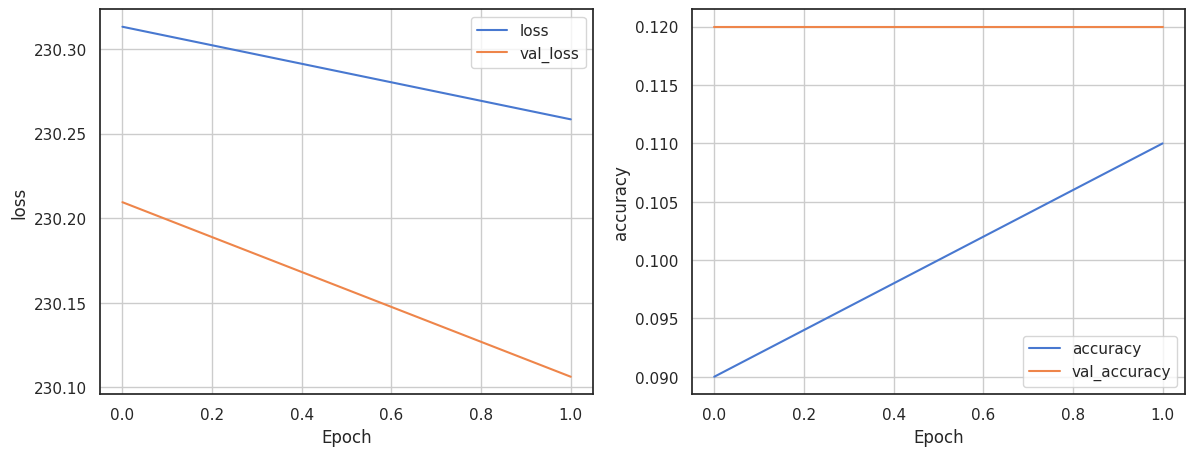

2/2 [==============================] - 4s 1s/step - loss: 2.3093 - accuracy: 0.0200


{'loss': 2.3093481063842773, 'accuracy': 0.019999999552965164}

2/2 [==============================] - 1s 14ms/step


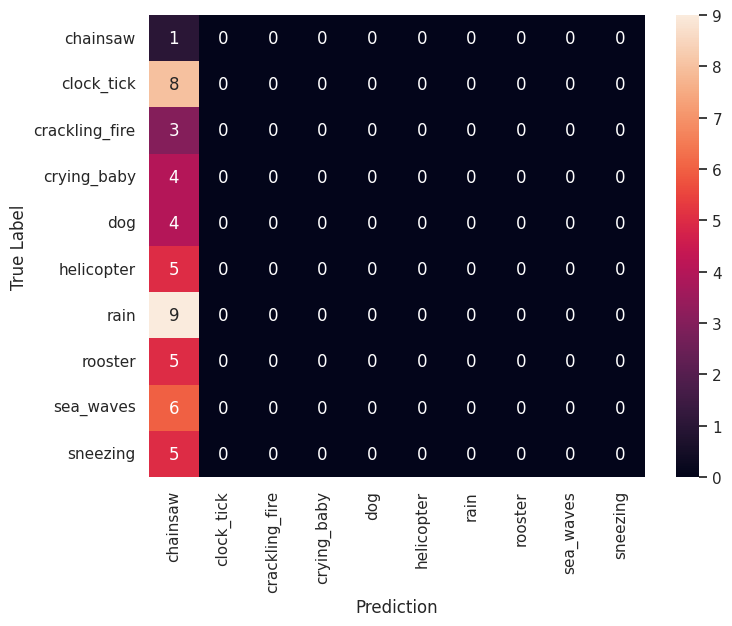

The most misclassified class is chainsaw
Audio category: chainsaw


The are more audio predicted as chainsaw then actually is:
Audio category misclassified as chainsaw: rain


In [41]:

#build the model with the best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
learning_rate = 1e-3
#learning_rate = best_params['learning_rate']
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

## 4.3 Classification on encoded spectrograms - CNN

Two out of five autoencoders produce a multichannel code, let's plot it before creating a classifiare for these new images.


In [ ]:
#need to match leo config
!pip install tensorflow==2.11.1
!pip install keras==2.11.0

### Short Time Fourier Transform

#### Create dataset

Preprocessing: STFT
Resizing with shape: 64x128
The max value is 80.0
Audio shape: (30, 64, 128, 1)
Label shape: (30, 10)
Label: dog


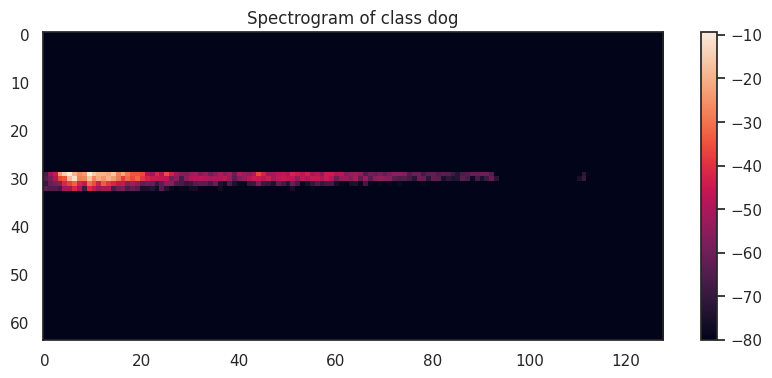

In [ ]:
batch_size = 30 if not strong_pc else 128
preprocessing = 'STFT'
n_dim = 3

dataset_STFT, label_STFT = create_dataset_lite(df_ESC10,
                                         batch_size = batch_size,
                                         preprocessing = preprocessing,
                                         ndim = n_dim,
                                         resize = True)

INPUT_DIM, n_labels = example_batch(dataset_STFT, label_names = list(label_STFT.columns),verbose=2, show_figure = True)

#### Load the encoders and build the model

We trained 2 AEs to produce a vectorial code. On these code we are going to train a RNN classifier.

In [8]:
AE_STFT = 'Fully_Convolutional_AE_STFT'

path_to_AE = os.path.join(main_dir, 'Saved_Models',AE_STFT)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_flat_code_STFT'

OSError: ignored

In [ ]:
def build_model(
        encoder = encoder,
        INPUT_DIM = INPUT_DIM,
        n_labels = n_labels,
        n_units = 8,
        activation = 'tanh',
        n_hidden_layers = 1,
        #arguments to compile the model
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        learning_rate = 1e-3,
        metrics = ['accuracy'],
        verbose = 0,
        compile = True
):

    # Define Simple RNN  model
    classifier = tf.keras.Sequential(name = 'classifier')
   #
   #
   #
   #
   #
    classifier.add(tf.keras.layers.Dense(n_labels, activation='softmax', name = 'Final_dense'))

    # build the model with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 1)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)

    if compile:
        # compile the model
        model.compile(loss = loss,
                      optimizer = optimizer,
                      metrics = metrics)
        if verbose > 0:
            display(model.summary())

    return model


In [ ]:
#model = build_model(encoder = encoder_list[0] , n_hidden_layers = 5 )
model = build_model( n_hidden_layers = 5 )

display(model.summary(line_length = 100))
display(model.layers[1].summary(line_length = 100))
display(model.layers[3].summary(line_length = 100))


#### Run a Grid Search to find the best hyperparameters

In [ ]:
params = {'n_hidden_layers':[2,4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh'], 'n_hidden_layers':[1,2,3,4]}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 2#5

model_cv, result, best_params = K_fold_training(dataset_STFT,
                                                build_model,
                                                params = params,
                                                epochs = epochs,
                                                patience = patience,
                                                verbose = verbose,
                                                K=K_fold)



(400, 64, 128, 1)
(400, 10)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
accuracy on test for this fold is 0.07
[CV 1/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.070) total time=   3.8s
accuracy on test for this fold is 0.135
[CV 2/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.135) total time=   5.3s
accuracy on test for this fold is 0.09
[CV 1/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.090) total time=  10.9s
accuracy on test for this fold is 0.06
[CV 2/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.060) total time=  10.8s
The best parameters are {'n_hidden_layers': 2}
The accuracy score are


mean_accuracy
{'n_hidden_layers': 2}         0.1025
{'n_hidden_layers': 4}         0.0750

#### Train the model

In [ ]:
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'Data', 'ESC-10-depth')

#create the dataset
batch_size = 30
preprocessing = 'STFT'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 3,
                                                                      resize = True
                                                                      )

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


Model: "encoder_classifier_flat_code_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 tf.expand_dims_15 (TFOpLamb  (None, 1, 32)            0         
 da)                                                             
                                                                 
 classifier (Sequential)     (None, 10)                2570      
                                                                 
Total params: 52,938
Trainable params: 2,570
Non-trainable params: 50,368
_________________________________________________________________
Epoch 1/2
10/10 [==============================] - 18s 2s/step - loss: 2.3623 - accuracy: 0

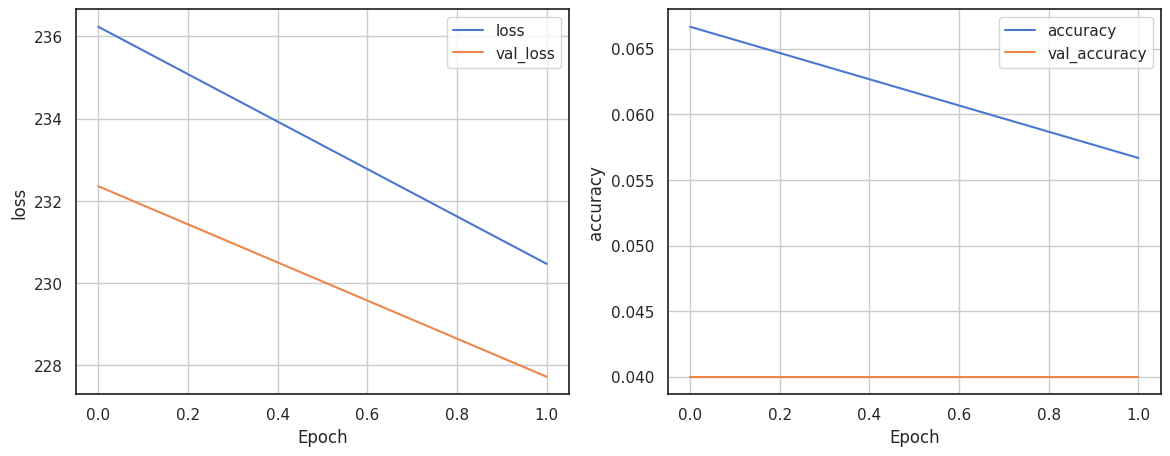

2/2 [==============================] - 2s 502ms/step - loss: 2.2979 - accuracy: 0.0600


{'loss': 2.2979094982147217, 'accuracy': 0.05999999865889549}

2/2 [==============================] - 0s 11ms/step


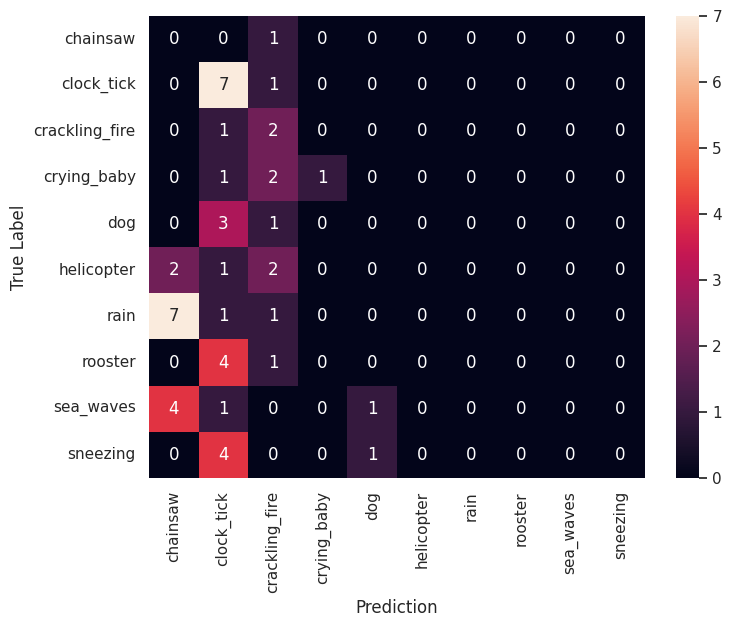

The most misclassified class is clock_tick
Audio category: clock_tick


The are more audio predicted as clock_tick then actually is:
Audio category misclassified as clock_tick: sneezing


In [ ]:
#build the model with the best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
#learning_rate = best_params['learning_rate']
learning_rate = 1e-3
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val, test, label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)

### Mel Frequency Cepstral Coefficients

#### Create the dataset

Preprocessing: MFCC
Resizing with shape: 64x128
The max value is 445.77911376953125
Audio shape: (30, 64, 128, 1)
Label shape: (30, 10)
Label: dog


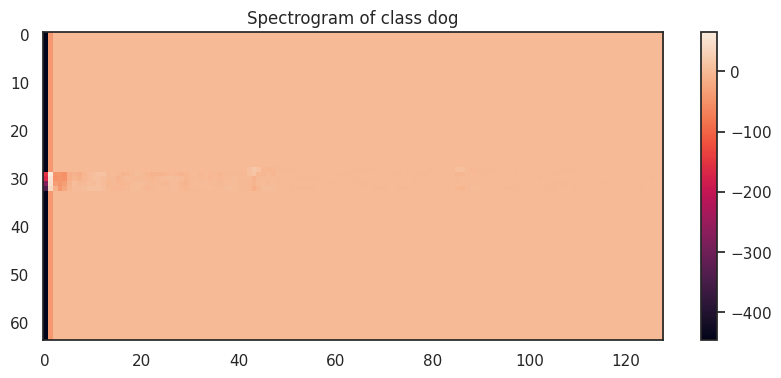

In [ ]:
batch_size = 30 if not strong_pc else 128
preprocessing = 'MFCC'
n_dim = 3

dataset_MFCC, label_MFCC = create_dataset_lite(df_ESC10,
                                         batch_size = batch_size,
                                         preprocessing = preprocessing,
                                         ndim = n_dim,
                                         resize = True)

INPUT_DIM, n_labels = example_batch(dataset_MFCC, label_names = list(label_MFCC.columns),verbose=2, show_figure = True)

#### Load the encoder and build the model

In [10]:
AE_MFCC = 'Fully_Convolutional_AE_MFCC'

path_to_AE = os.path.join(main_dir, 'Saved_Models',AE_MFCC)

#import the autencoder
autoencoder = load_model(path_to_AE)
encoder = autoencoder.layers[1]

# freeze the encoder
encoder.trainable = False
encoder.summary()

Classifier_name = 'encoder_classifier_flat_code_MFCC'

AttributeError: ignored

In [ ]:
def build_model(
        encoder = encoder,
        INPUT_DIM = INPUT_DIM,
        n_labels = n_labels,
        n_units = 8,
        activation = 'tanh',
        n_hidden_layers = 1,
        #arguments to compile the model
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        learning_rate = 1e-3,
        metrics = ['accuracy'],
        verbose = 0,
        compile = True
):

    # Define Simple RNN  model
    classifier = tf.keras.Sequential(name = 'classifier')

   #
   #
   #
   #
   #

    classifier.add(tf.keras.layers.Dense(n_labels, activation='softmax', name = 'Final_dense'))

    # build the model with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    # add 1 dimension to the code
    code = tf.expand_dims(code, axis = 1)
    output = classifier(code)
    model = tf.keras.Model(inputs=inp, outputs=output, name = Classifier_name)

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)

    if compile:
        # compile the model
        model.compile(loss = loss,
                      optimizer = optimizer,
                      metrics = metrics)
        if verbose > 0:
            display(model.summary())

    return model


In [ ]:
#model = build_model(encoder = encoder_list[0] , n_hidden_layers = 5 )
model = build_model( n_hidden_layers = 5 )

display(model.summary(line_length = 100))
display(model.layers[1].summary(line_length = 100))
display(model.layers[3].summary(line_length = 100))


#### Run a grid search to find the best params

In [ ]:
params = {'n_hidden_layers':[2,4]}
#params = {'learning_rate':[1e-2, 1e-3, 1e-4],'n_units':[8,32,128],'activation':['relu','elu','tanh'], 'n_hidden_layers':[1,2,3,4]}
epochs = 1 if not strong_pc else 100
patience = 10
verbose = 3
K_fold = 2#5

model_cv, result, best_params = K_fold_training(dataset_MFCC,
                                                build_model,
                                                params = params,
                                                epochs = epochs,
                                                patience = patience,
                                                verbose = verbose,
                                                K=K_fold)

(400, 64, 128, 1)
(400, 10)
Fitting 2 folds for each of 2 candidates, totalling 4 fits
accuracy on test for this fold is 0.075
[CV 1/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.075) total time=   4.1s
accuracy on test for this fold is 0.105
[CV 2/2] END n_hidden_layers=2; one_hot_accuracy: (test=0.105) total time=   5.4s
accuracy on test for this fold is 0.145
[CV 1/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.145) total time=  11.8s
accuracy on test for this fold is 0.155
[CV 2/2] END n_hidden_layers=4; one_hot_accuracy: (test=0.155) total time=  11.8s
The best parameters are {'n_hidden_layers': 4}
The accuracy score are


mean_accuracy
{'n_hidden_layers': 4}           0.15
{'n_hidden_layers': 2}           0.09

#### Train the model

In [ ]:
seed = 42
tf.random.set_seed(seed)

path_to_ESC10 = os.path.join(main_dir,'Data', 'ESC-10-depth')

#create the dataset
batch_size = 30 if not strong_pc else 128
preprocessing = 'MFCC'
train, val, test, label_names, INPUT_DIM, n_labels = create_dataset(path_to_ESC10,
                                                                      batch_size = batch_size,  # batch size
                                                                      preprocessing = preprocessing,
                                                                      verbose = 0,
                                                                      show_example_batch = True,
                                                                      ndim = 3,
                                                                      resize = True
                                                                      )


Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.


Model: "encoder_classifier_flat_code_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                20240     
                                                                 
 tf.expand_dims_21 (TFOpLamb  (None, 1, 32)            0         
 da)                                                             
                                                                 
 classifier (Sequential)     (None, 10)                11322     
                                                                 
Total params: 31,562
Trainable params: 11,322
Non-trainable params: 20,240
_________________________________________________________________
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 10s 443ms/step - loss: 2.3031 - accuracy: 0.0900 - val_loss: 2.3021 - val_accuracy: 0.1200
Epoch 2/2
10/10 [==============================] - 0s 26ms/step - loss: 2.3026 - accuracy: 0.1100 - val_loss: 2.3011 - val_accuracy: 0.1200


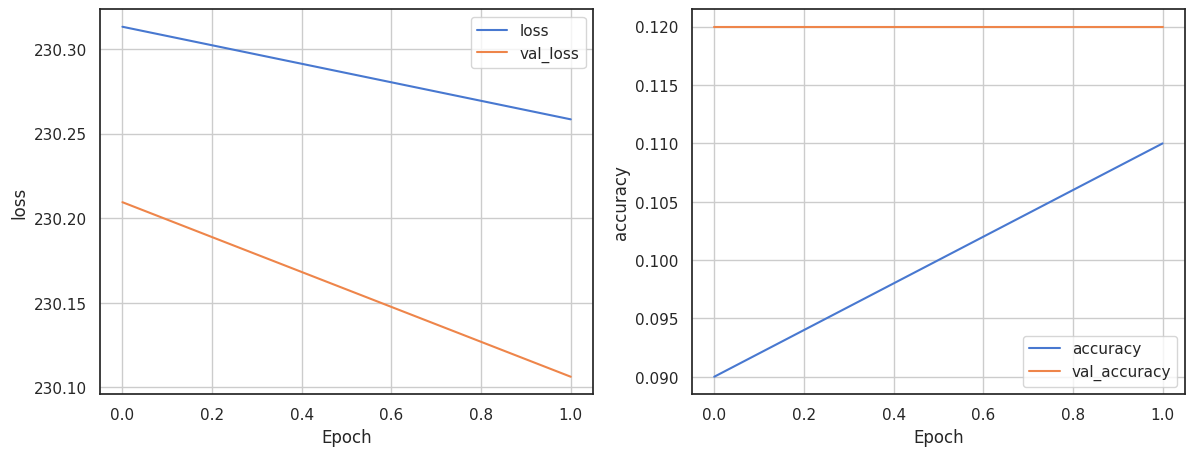

2/2 [==============================] - 4s 1s/step - loss: 2.3093 - accuracy: 0.0200


{'loss': 2.3093481063842773, 'accuracy': 0.019999999552965164}

2/2 [==============================] - 1s 14ms/step


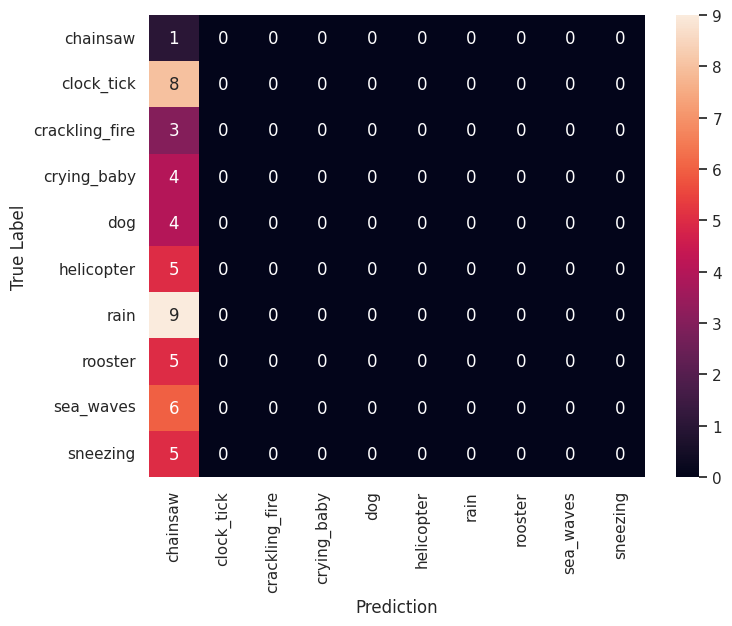

The most misclassified class is chainsaw
Audio category: chainsaw


The are more audio predicted as chainsaw then actually is:
Audio category misclassified as chainsaw: rain


In [ ]:

#build the model with the best parameters
model = build_model(n_labels = n_labels, compile = False, **best_params)
learning_rate = 1e-3
#learning_rate = best_params['learning_rate']
epochs =  2 if not strong_pc else 100
patience = 10
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate=learning_rate)
model, history, confusion_mtx, evaluation = compile_fit_evaluate(df_ESC10, model, train, val,test,label_names,
                                     epochs = epochs,
                                     patience = patience,
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     optimizer = optimizer,
                                     metrics = ['accuracy'],
                                     verbose = 1,
                                     show_history = True,
                                     show_test_evaluation = True,
                                     show_confusion_matrix = True,
                                     listen_to_wrong = True)